In [1]:
import numpy as np
from numba import jit

# Funciones de prueba
@jit(nopython=True)
def Sphere(arr):
    suma = 0.0
    for x in arr:
        suma += x ** 2
    return suma

intervaloSphere = (-5.12, 5.12)

@jit(nopython=True)
def Ackley(arr):
    suma1 = 0.0
    suma2 = 0.0
    n = arr.shape[0]
    for x in arr:
        suma1 += x ** 2
        suma2 += np.cos(2 * np.pi * x)
    term1 = 20 + np.exp(1) - 20 * np.exp(-0.2 * np.sqrt(suma1 / n))
    term2 = np.exp(suma2 / n)
    return term1 - term2

intervaloAckley = (-30, 30)

@jit(nopython=True)
def Griewank(arr):
    suma = 0.0
    m = 1.0
    n = arr.shape[0]
    for i in range(1, n + 1):
        x_i = arr[i - 1]
        suma += (x_i ** 2) / 4000.0
        m *= np.cos(x_i / np.sqrt(i))
    return 1 + suma - m

intervaloGriewank = (-600, 600)

@jit(nopython=True)
def Rastrigin(arr):
    n = arr.shape[0]
    suma = 0.0
    for x in arr:
        suma += x ** 2 - 10 * np.cos(2 * np.pi * x)
    return 10 * n + suma

intervaloRastrigin = (-5.12, 5.12)

@jit(nopython=True)
def Rosenbrock(x):
    n = x.shape[0]
    suma = 0.0
    for i in range(n - 1):
        suma += 100 * (x[i + 1] - (x[i]) ** 2) ** 2 + (x[i] - 1) ** 2
    return suma

intervaloRosenbrock = (-2.048, 2.048)


c:\Users\usuario\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# Codificación y decodificación binaria
@jit(nopython=True)
def codifica_real(x, n_bit, intervalo):
    a, b = intervalo
    precision = (b - a) / ((2 ** n_bit) - 1)
    x = max(a, min(b, x))
    index = int((x - a) / precision)
    x_binario = np.zeros(n_bit, dtype=np.int64)
    for i in range(n_bit - 1, -1, -1):
        x_binario[i] = index & 1
        index >>= 1
    return x_binario

@jit(nopython=True)
def codifica_vector(vector_reales, n_bit, intervalo):
    vector_binario = np.empty((len(vector_reales), n_bit), dtype=np.int64)
    for i in range(len(vector_reales)):
        vector_binario[i] = codifica_real(vector_reales[i], n_bit, intervalo)
    return vector_binario

@jit(nopython=True)
def decodifica(x_cod, n_bits, intervalo):
    a, b = intervalo
    precision = (b - a) / ((2 ** n_bits) - 1)
    indice = 0
    for i in range(len(x_cod)):
        indice = (indice << 1) | x_cod[i]
    return a + indice * precision

@jit(nopython=True)
def decodifica_vector(vector_binario, n_bits, intervalo):
    vector_reales = np.empty(vector_binario.shape[0])
    for i in range(vector_binario.shape[0]):
        vector_reales[i] = decodifica(vector_binario[i], n_bits, intervalo)
    return vector_reales

In [3]:
@jit(nopython=True)
def distancia_ham_normalizada(sol1, sol2):
    # Suponiendo que sol1 y sol2 son arreglos de numpy
    if sol1.size != sol2.size:
        raise ValueError("Las soluciones deben tener el mismo tamaño")
    return np.sum(sol1 != sol2) / sol1.size

@jit(nopython=True)
def diversidad_promedio(poblacion):  # recibe una matriz de matrices
    n = poblacion.shape[0]  # tamaño de la población
    matriz = np.zeros((n, n))  # inicializamos matriz de distancias
    for i in range(n):  # Itera sobre cada individuo
        for j in range(i + 1, n):  # Solo itera sobre la mitad triangular superior derecha
            distancia = distancia_ham_normalizada(poblacion[i], poblacion[j])
            matriz[i][j] = distancia  # Almacena la distancia en la matriz
            matriz[j][i] = distancia  # La distancia es la misma de j a i
    suma = np.sum(matriz) / n  # suma todas las distancias y las normaliza
    suma_prom = suma / n  # obtiene promedio de las distancias normalizadas
    return suma_prom

@jit(nopython=True)
def diversidad_minima_promedio(poblacion):
    n = poblacion.shape[0]  # tamaño de la población
    lista_minimos = np.zeros(n)

    for i in range(n):  # para cada individuo
        minimo = np.inf  # Cambié 10 a np.inf para una comparación más general

        for j in range(n):  # lo comparamos con los demás
            if i != j:
                distancia = distancia_ham_normalizada(poblacion[i], poblacion[j])
                if distancia < minimo:  # si la distancia es menor a la mínima actual
                    minimo = distancia  # actualizamos el mínimo
        lista_minimos[i] = minimo  # asignamos el mínimo encontrado para el individuo i
    
    # Sacamos el promedio de los mínimos
    promedio = np.sum(lista_minimos) / n
    return promedio


In [4]:
@jit(nopython=True)
def Entropia_Total(poblacion):
    nIndividuos, nCromosomas, nBits = poblacion.shape
    entropiasPorGen = np.zeros(nBits)
    totalBits = nIndividuos * nCromosomas  # Calculado una vez

    for b in range(nBits):
        conteo_1s = 0
        for i in range(nIndividuos):
            for j in range(nCromosomas):
                conteo_1s += poblacion[i, j, b]

        conteo_0s = totalBits - conteo_1s
        p_1 = conteo_1s / totalBits
        p_0 = conteo_0s / totalBits

        entropia_gen = 0.0
        if p_1 > 0:
            entropia_gen -= p_1 * (np.log(p_1) / np.log(2))  # Usar log natural
        if p_0 > 0:
            entropia_gen -= p_0 * (np.log(p_0) / np.log(2))  # Usar log natural

        entropiasPorGen[b] = entropia_gen

    entropia_total = np.sum(entropiasPorGen) / nBits
    return entropia_total

In [33]:
# Función para generar una solución inicial
@jit(nopython=True)
def generar_solucion_inicial(n, n_bits, intervalo):
    solucion_reales = np.random.uniform(intervalo[0], intervalo[1], n)
    solucion_binaria = codifica_vector(solucion_reales, n_bits, intervalo)
    return solucion_binaria, solucion_reales

In [24]:
sol_bin, sol_real = generar_solucion_inicial(4, 20, (-3, 3))
decodifica_vector(sol_bin,20,(-3,3))

array([-2.0341864 , -1.56547028,  2.16840855,  2.1232444 ])

In [37]:
@jit(nopython=True)
def generar_vecino(solucion_binaria, n_bits, intervalo):
    """
    Recibe una solucion inicial binaria y devuelve UN vecino aleatorio de la vecindad 1 flip 
    """
    n_variables = solucion_binaria.shape[0] 
    vecino_binario = solucion_binaria.copy() # partimos de una copia para modificar al vecino

    bit_a_mutar = np.random.randint(0, n_bits) # elegimos aleatoriamente el bit que vamos a modificar
    i = np.random.randint(0, n_variables) # Elegimos el escalar que vamos a cambiar
    vecino_binario[i][bit_a_mutar] = 1 - vecino_binario[i][bit_a_mutar]
    return vecino_binario


In [39]:
generar_vecino(sol_bin, 20, (-3,3))

array([[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0],
       [1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1]],
      dtype=int64)

In [200]:
import numpy as np
from numba import jit

@jit(nopython=True)
def Recocido_Simulado(funcion, intervalo, dimension, n_bits, iteraciones, temperatura_inicial, esquema_enfriamiento):
    # Inicializamos a la mejor y actual soluciones como un vector aleatorio y guardamos sus evaluaciones
    sol_actual_binaria, sol_actual_real = generar_solucion_inicial(dimension, n_bits, intervalo)
    sol_mejor_binaria = sol_actual_binaria
    T = temperatura_inicial

    # Inicializamos listas donde guardaremos las mejores soluciones 
    mejores_soluciones_binarias = np.zeros((iteraciones, 10, n_bits), dtype=np.int64)
    mejores_evaluaciones = np.zeros(iteraciones)
    activas_soluciones_binarias = np.zeros((iteraciones, 10, n_bits), dtype=np.int64)
    activas_evaluaciones = np.zeros(iteraciones)

    for i in range(iteraciones):
        # Generamos aleatoriamente un vecino de la solución actual
        vecino_binario = generar_vecino(sol_actual_binaria, n_bits, intervalo)
        # Decodificamos al vecino
        vecino_real = decodifica_vector(vecino_binario, n_bits, intervalo)
        # Decodificamos a la mejor solución binaria
        sol_mejor_real = decodifica_vector(sol_mejor_binaria, n_bits, intervalo)

        # Aceptamos al vecino si su evaluación es menor que la mejor
        if funcion(vecino_real) < funcion(sol_mejor_real):
            sol_mejor_binaria = vecino_binario
            sol_mejor_real = vecino_real
            sol_actual_binaria = vecino_binario
        else:
            # Probabilidad de aceptación
            delta_f = funcion(vecino_real) - funcion(sol_mejor_real)
            if np.random.rand() < np.exp(-delta_f / T):
                sol_actual_binaria = vecino_binario

        # Actualización de temperatura
        if esquema_enfriamiento == 'Lineal':
            T = max(0.0000000000001, temperatura_inicial - (0.6) * (i + 1))
        elif esquema_enfriamiento == 'Geometrico':
            T *= 0.8

        # Ahora la actual 
        sol_actual_real = decodifica_vector(sol_actual_binaria, n_bits, intervalo)

        # Guardamos las mejores soluciones
        mejores_soluciones_binarias[i] = sol_mejor_binaria
        mejores_evaluaciones[i] = funcion(sol_mejor_real)
        activas_soluciones_binarias[i]= sol_actual_binaria
        activas_evaluaciones[i] = funcion(sol_actual_real)

    return mejores_soluciones_binarias, mejores_evaluaciones, activas_soluciones_binarias, activas_evaluaciones
    

## Ahora graficamos para recocido simulado


In [190]:
dimension=10
n_bits = 20
T_inicial = 500
iteraciones = 1000

### Rosenbrock

In [201]:
# Rosenbrock Lineal 
mejores_soluciones_binariasRL, mejores_evaluacionesRL, activas_soluciones_binariasRL, activas_evaluacionesRL = Recocido_Simulado(Rosenbrock, intervaloRosenbrock, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Lineal')

# Rosenbrock Geometrico
mejores_soluciones_binariasRG, mejores_evaluacionesRG, activas_soluciones_binariasRG, activas_evaluacionesRG = Recocido_Simulado(Rosenbrock, intervaloRosenbrock, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Geometrico')


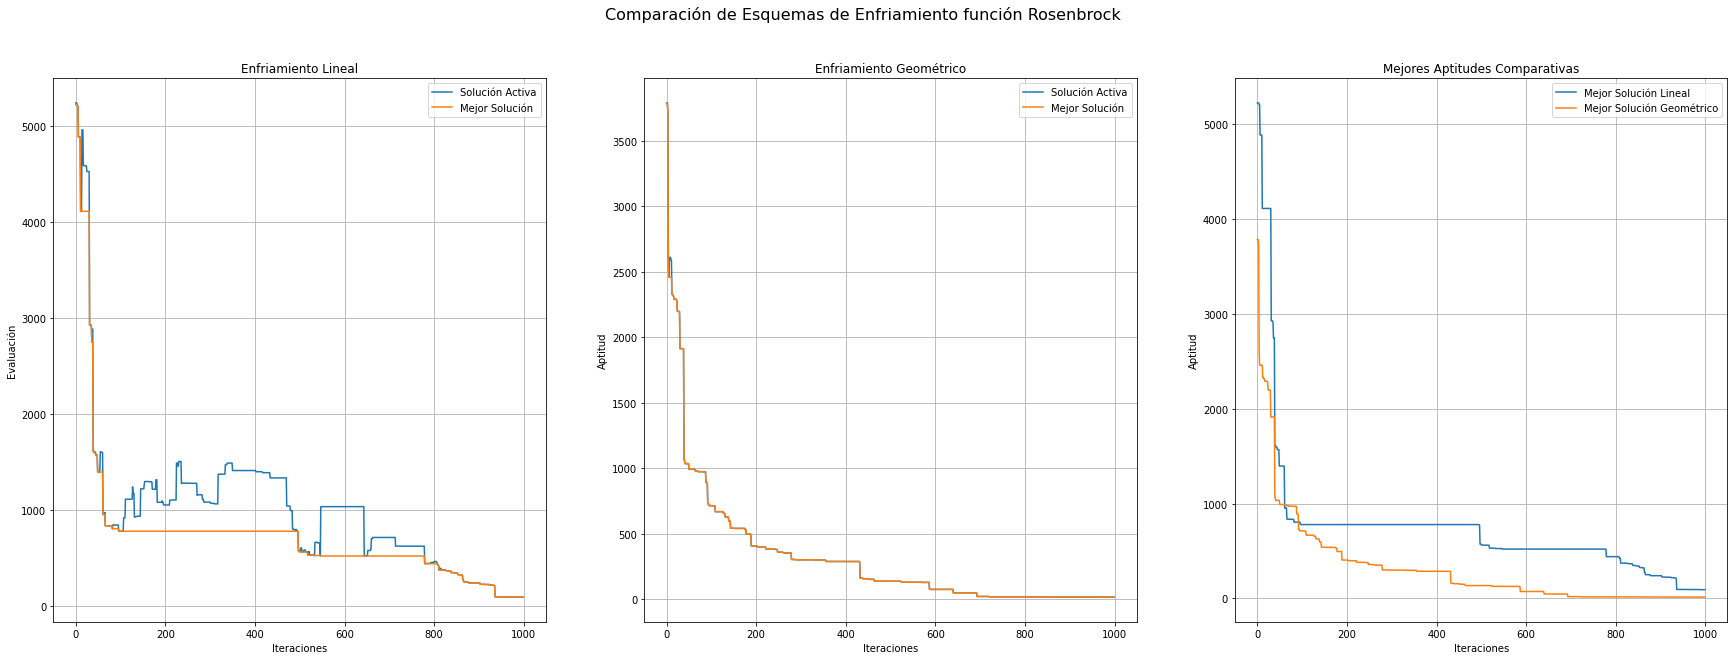

In [204]:

import matplotlib.pyplot as plt


# Configuramos la figura y los ejes
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

plt.suptitle('Comparación de Esquemas de Enfriamiento función Rosenbrock', fontsize=16)

# Gráfica 1: Aptitudes promedio y mejores (Enfriamiento Lineal)
axs[0].plot(activas_evaluacionesRL, label='Solución Activa')
axs[0].plot(mejores_evaluacionesRL, label='Mejor Solución')
axs[0].set_title('Enfriamiento Lineal')
axs[0].set_xlabel('Iteraciones')
axs[0].set_ylabel('Evaluación')
axs[0].legend()
axs[0].grid()

# Gráfica 2: Aptitudes promedio y mejores (Enfriamiento Geométrico)
axs[1].plot(activas_evaluacionesRG, label='Solución Activa')
axs[1].plot(mejores_evaluacionesRG, label='Mejor Solución')
axs[1].set_title('Enfriamiento Geométrico')
axs[1].set_xlabel('Iteraciones')
axs[1].set_ylabel('Aptitud')
axs[1].legend()
axs[1].grid()

# Gráfica 3: Mejores de esquema lineal y geométrico
axs[2].plot(mejores_evaluacionesRL, label='Mejor Solución Lineal')
axs[2].plot(mejores_evaluacionesRG, label='Mejor Solución Geométrico')
axs[2].set_title('Mejores Aptitudes Comparativas')
axs[2].set_xlabel('Iteraciones')
axs[2].set_ylabel('Aptitud')
axs[2].legend()
axs[2].grid()

plt.show()

### Ackley


In [205]:
# Ackley Lineal 
mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Ackley, intervaloAckley, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Lineal')

# Ackley Geometrico
mejores_soluciones_binariasAG, mejores_evaluacionesAG, activas_soluciones_binariasAG, activas_evaluacionesAG = Recocido_Simulado(Ackley, intervaloAckley, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Geometrico')


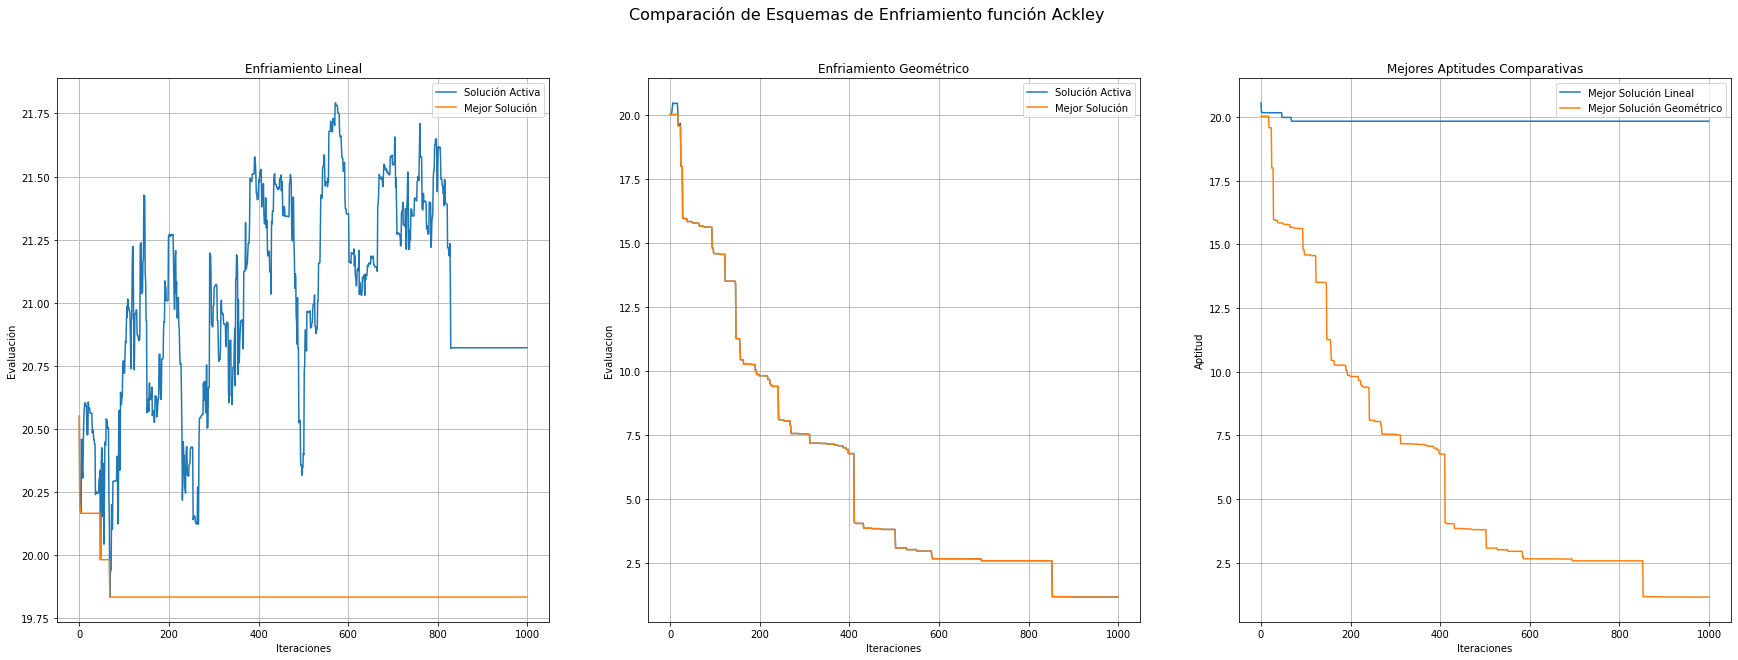

In [206]:
# Configuramos la figura y los ejes
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

plt.suptitle('Comparación de Esquemas de Enfriamiento función Ackley', fontsize=16)

# Gráfica 1: Aptitudes promedio y mejores (Enfriamiento Lineal)
axs[0].plot(activas_evaluacionesAL, label='Solución Activa')
axs[0].plot(mejores_evaluacionesAL, label='Mejor Solución')
axs[0].set_title('Enfriamiento Lineal')
axs[0].set_xlabel('Iteraciones')
axs[0].set_ylabel('Evaluación')
axs[0].legend()
axs[0].grid()

# Gráfica 2: Aptitudes promedio y mejores (Enfriamiento Geométrico)
axs[1].plot(activas_evaluacionesAG, label='Solución Activa')
axs[1].plot(mejores_evaluacionesAG, label='Mejor Solución')
axs[1].set_title('Enfriamiento Geométrico')
axs[1].set_xlabel('Iteraciones')
axs[1].set_ylabel('Evaluacion')
axs[1].legend()
axs[1].grid()

# Gráfica 3: Mejores de esquema lineal y geométrico
axs[2].plot(mejores_evaluacionesAL, label='Mejor Solución Lineal')
axs[2].plot(mejores_evaluacionesAG, label='Mejor Solución Geométrico')
axs[2].set_title('Mejores Aptitudes Comparativas')
axs[2].set_xlabel('Iteraciones')
axs[2].set_ylabel('Aptitud')
axs[2].legend()
axs[2].grid()

plt.show()

### Sphere 

In [207]:
# Sphere Lineal 
mejores_soluciones_binariasSL, mejores_evaluacionesSL, activas_soluciones_binariasSL, activas_evaluacionesSL = Recocido_Simulado(Sphere, intervaloSphere, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Lineal')

# Sphere Geometrico
mejores_soluciones_binariasSG, mejores_evaluacionesSG, activas_soluciones_binariasSG, activas_evaluacionesSG = Recocido_Simulado(Sphere, intervaloSphere, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Geometrico')


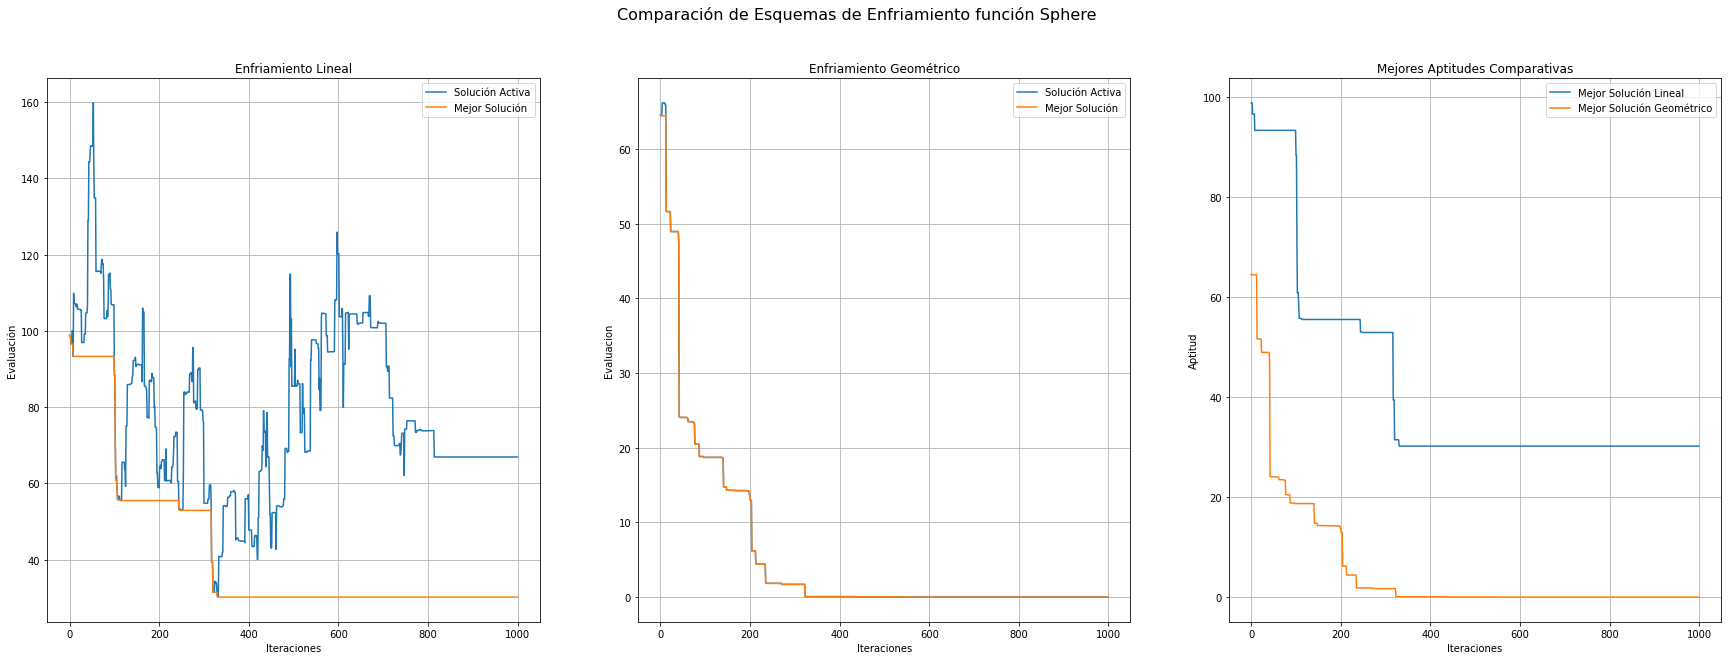

In [208]:
# Configuramos la figura y los ejes
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

plt.suptitle('Comparación de Esquemas de Enfriamiento función Sphere', fontsize=16)

# Gráfica 1: Aptitudes promedio y mejores (Enfriamiento Lineal)
axs[0].plot(activas_evaluacionesSL, label='Solución Activa')
axs[0].plot(mejores_evaluacionesSL, label='Mejor Solución')
axs[0].set_title('Enfriamiento Lineal')
axs[0].set_xlabel('Iteraciones')
axs[0].set_ylabel('Evaluación')
axs[0].legend()
axs[0].grid()

# Gráfica 2: Aptitudes promedio y mejores (Enfriamiento Geométrico)
axs[1].plot(activas_evaluacionesSG, label='Solución Activa')
axs[1].plot(mejores_evaluacionesSG, label='Mejor Solución')
axs[1].set_title('Enfriamiento Geométrico')
axs[1].set_xlabel('Iteraciones')
axs[1].set_ylabel('Evaluacion')
axs[1].legend()
axs[1].grid()

# Gráfica 3: Mejores de esquema lineal y geométrico
axs[2].plot(mejores_evaluacionesSL, label='Mejor Solución Lineal')
axs[2].plot(mejores_evaluacionesSG, label='Mejor Solución Geométrico')
axs[2].set_title('Mejores Aptitudes Comparativas')
axs[2].set_xlabel('Iteraciones')
axs[2].set_ylabel('Aptitud')
axs[2].legend()
axs[2].grid()

plt.show()

### Griewank 

In [209]:
# Griewank Lineal 
mejores_soluciones_binariasGL, mejores_evaluacionesGL, activas_soluciones_binariasGL, activas_evaluacionesGL = Recocido_Simulado(Griewank, intervaloGriewank, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Lineal')

# Griewank Geometrico
mejores_soluciones_binariasGG, mejores_evaluacionesGG, activas_soluciones_binariasGG, activas_evaluacionesGG = Recocido_Simulado(Griewank, intervaloGriewank, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Geometrico')


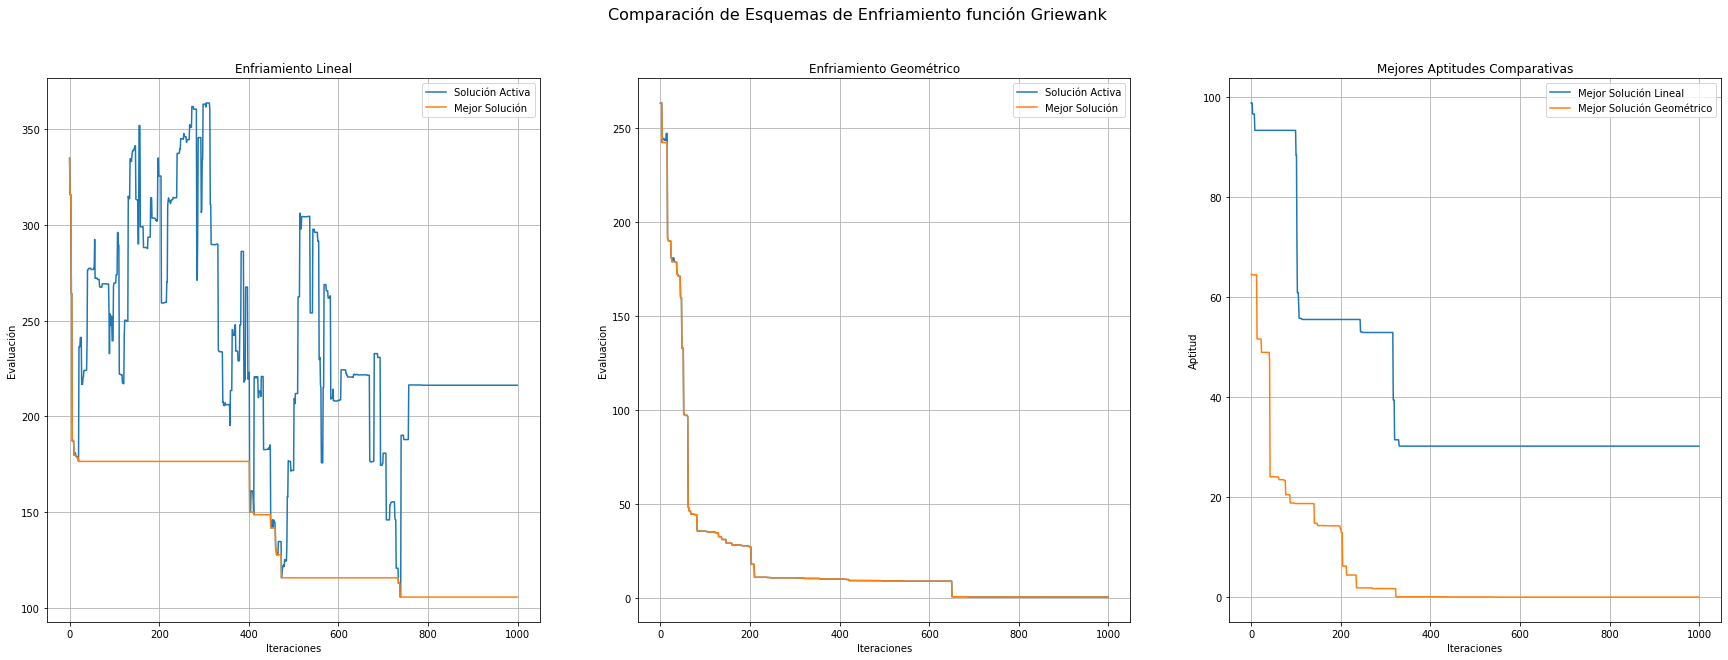

In [210]:
# Configuramos la figura y los ejes
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

plt.suptitle('Comparación de Esquemas de Enfriamiento función Griewank', fontsize=16)

# Gráfica 1: Aptitudes promedio y mejores (Enfriamiento Lineal)
axs[0].plot(activas_evaluacionesGL, label='Solución Activa')
axs[0].plot(mejores_evaluacionesGL, label='Mejor Solución')
axs[0].set_title('Enfriamiento Lineal')
axs[0].set_xlabel('Iteraciones')
axs[0].set_ylabel('Evaluación')
axs[0].legend()
axs[0].grid()

# Gráfica 2: Aptitudes promedio y mejores (Enfriamiento Geométrico)
axs[1].plot(activas_evaluacionesGG, label='Solución Activa')
axs[1].plot(mejores_evaluacionesGG, label='Mejor Solución')
axs[1].set_title('Enfriamiento Geométrico')
axs[1].set_xlabel('Iteraciones')
axs[1].set_ylabel('Evaluacion')
axs[1].legend()
axs[1].grid()

# Gráfica 3: Mejores de esquema lineal y geométrico
axs[2].plot(mejores_evaluacionesSL, label='Mejor Solución Lineal')
axs[2].plot(mejores_evaluacionesSG, label='Mejor Solución Geométrico')
axs[2].set_title('Mejores Aptitudes Comparativas')
axs[2].set_xlabel('Iteraciones')
axs[2].set_ylabel('Aptitud')
axs[2].legend()
axs[2].grid()

plt.show()

### Rastrigin 

In [211]:
# Rastrigin Lineal 
mejores_soluciones_binariasNL, mejores_evaluacionesNL, activas_soluciones_binariasNL, activas_evaluacionesNL = Recocido_Simulado(Rastrigin, intervaloRastrigin, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Lineal')

# Rastrigin Geometrico
mejores_soluciones_binariasNG, mejores_evaluacionesNG, activas_soluciones_binariasNG, activas_evaluacionesNG = Recocido_Simulado(Rastrigin, intervaloRastrigin, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Geometrico')
    

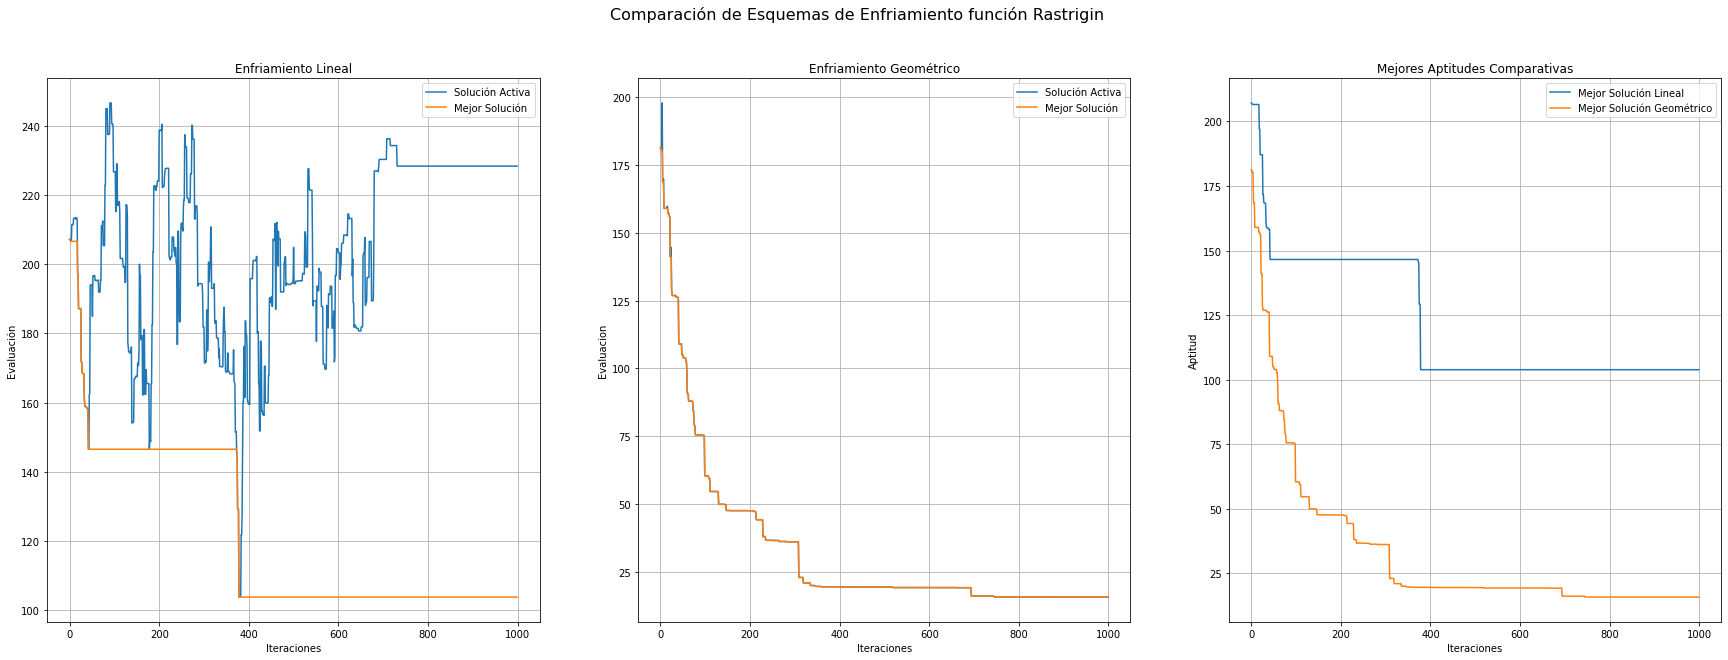

In [212]:
# Configuramos la figura y los ejes
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

plt.suptitle('Comparación de Esquemas de Enfriamiento función Rastrigin', fontsize=16)

# Gráfica 1: Aptitudes promedio y mejores (Enfriamiento Lineal)
axs[0].plot(activas_evaluacionesNL, label='Solución Activa')
axs[0].plot(mejores_evaluacionesNL, label='Mejor Solución')
axs[0].set_title('Enfriamiento Lineal')
axs[0].set_xlabel('Iteraciones')
axs[0].set_ylabel('Evaluación')
axs[0].legend()
axs[0].grid()

# Gráfica 2: Aptitudes promedio y mejores (Enfriamiento Geométrico)
axs[1].plot(activas_evaluacionesNG, label='Solución Activa')
axs[1].plot(mejores_evaluacionesNG, label='Mejor Solución')
axs[1].set_title('Enfriamiento Geométrico')
axs[1].set_xlabel('Iteraciones')
axs[1].set_ylabel('Evaluacion')
axs[1].legend()
axs[1].grid()

# Gráfica 3: Mejores de esquema lineal y geométrico
axs[2].plot(mejores_evaluacionesNL, label='Mejor Solución Lineal')
axs[2].plot(mejores_evaluacionesNG, label='Mejor Solución Geométrico')
axs[2].set_title('Mejores Aptitudes Comparativas')
axs[2].set_xlabel('Iteraciones')
axs[2].set_ylabel('Aptitud')
axs[2].legend()
axs[2].grid()

plt.show()

(esto ya es otra sección que va a tener sentido en el futuro, espero)

In [169]:
"""
import matplotlib.pyplot as plt

# Función para generar las gráficas del esquema de enfriamiento lineal:
def graficar_resultados_Lineal(aptitud_mejor, diversidad_prom, diversidad_min, entropia_generacional,
                        funcion='Función Desconocida', semilla=None):
    
    # Crear una figura y tres ejes
    fig, axs = plt.subplots(3, 1, figsize=(20, 24))  # 3 filas, 1 columna

    # Convertir la semilla a texto si existe
    semilla_str = f", semilla {semilla}" if semilla is not None else ""

    # Primera gráfica: Aptitudes
    axs[0].plot(aptitud_mejor, label='Mejor Evaluación', linestyle='--')
    axs[0].set_title(f'Aptitudes en {funcion} con esquema de enfriamiento lineal{semilla_str}')
    axs[0].set_xlabel('Iteraciones')
    axs[0].set_ylabel('Evaluación')
    axs[0].legend()
    axs[0].grid()

    # Segunda gráfica: Diversidad
    axs[1].plot(diversidad_prom, label='Diversidad Promedio', linestyle='-')
    axs[1].plot(diversidad_min, label='Diversidad Mínima', linestyle='--')
    axs[1].set_title(f'Diversidad del ejemplar {funcion}, con esquema de enfriamiento lineal{semilla_str}')
    axs[1].set_xlabel('Iteraciones')
    axs[1].set_ylabel('Diversidad')
    axs[1].legend()
    axs[1].grid()

    # Tercera gráfica: Entropía
    axs[2].plot(entropia_generacional, label='Entropía', linestyle='-')
    axs[2].set_title(f'Entropía en el ejemplar {funcion} con esquema de enfriamiento lineal{semilla_str}')
    axs[2].set_xlabel('Iteraciones')
    axs[2].set_ylabel('Entropía')
    axs[2].legend()
    axs[2].grid()

    # Ajustar el espacio entre las gráficas
    plt.tight_layout()

    # Mostrar las gráficas
    plt.show()
    """


In [170]:
""""
# Función para generar las gráficas del esquema de reemplazo Generacional:
def graficar_resultados_Geometrico(aptitud_mejor, diversidad_prom, diversidad_min, entropia_generacional,
                        funcion='Función Desconocida', semilla=None):
    
    # Crear una figura y tres ejes
    fig, axs = plt.subplots(3, 1, figsize=(20, 24))  # 3 filas, 1 columna

    # Convertir la semilla a texto si existe
    semilla_str = f", semilla {semilla}" if semilla is not None else ""

    # Primera gráfica: Aptitudes
    axs[0].plot(aptitud_mejor, label='Mejor Evaluación', linestyle='--')
    axs[0].set_title(f'Aptitudes en {funcion} con esquema de enfriamento geométrico{semilla_str}')
    axs[0].set_xlabel('Iteraciones')
    axs[0].set_ylabel('Evaluación')
    axs[0].legend()
    axs[0].grid()

    # Segunda gráfica: Diversidad
    axs[1].plot(diversidad_prom, label='Diversidad Promedio', linestyle='-')
    axs[1].plot(diversidad_min, label='Diversidad Mínima', linestyle='--')
    axs[1].set_title(f'Diversidad del ejemplar {funcion}, con esquema de enfriamento geométrico{semilla_str}')
    axs[1].set_xlabel('Iteraciones')
    axs[1].set_ylabel('Diversidad')
    axs[1].legend()
    axs[1].grid()

    # Tercera gráfica: Entropía
    axs[2].plot(entropia_generacional, label='Entropía', linestyle='-')
    axs[2].set_title(f'Entropía en el ejemplar {funcion} con esquema de enfriamento geométrico{semilla_str}')
    axs[2].set_xlabel('Iteraciones')
    axs[2].set_ylabel('Entropía')
    axs[2].legend()
    axs[2].grid()

    # Ajustar el espacio entre las gráficas
    plt.tight_layout()

    # Mostrar las gráficas
    plt.show()
"""

In [171]:
"""
def ejecutar_algoritmo_y_graficar(funcion, intervalo, ejecuciones=1, iteraciones=1000):
    n=10
    n_bits = 20
    T_inicial = 500
    iteraciones = 1000

    # Ponemos la semilla 
    seed = 1729455745
    np.random.seed(seed)
     # Inicializamos listas donde guardaremos las iteraciones 
    aptitud_promedio = np.zeros(iteraciones)
    aptitud_mejor = np.zeros(iteraciones)
    diversidad_prom = np.zeros(iteraciones)
    diversidad_min = np.zeros(iteraciones)
    entropia_generacional = np.zeros(iteraciones)

    # Ejecutamos el algoritmo para enfriamiento lineal
    mejores_soluciones_binarias, mejores_evaluaciones = Recocido_Simulado(funcion, intervalo, n, n_bits, iteraciones, T_inicial, 'Lineal')

    aptitud_mejorE = mejores_evaluaciones
    diversidad_promE = diversidad_promedio(mejores_soluciones_binarias)
    diversidad_minE = diversidad_minima_promedio(mejores_soluciones_binarias)
    entropia_generacionalE = Entropia_Total(mejores_soluciones_binarias)

    # Graficamos elitismo:
    graficar_resultados_Lineal(aptitud_mejorE, diversidad_promE, diversidad_minE, entropia_generacionalE,
                        funcion, semilla=seed)
    

    # Ponemos la semilla para el geometrico
    seed = 1729455759
    np.random.seed(seed)
    # Ejecutamos el algoritmo para enfriamiento geometrico
    mejores_soluciones_binarias, mejores_evaluaciones = Recocido_Simulado(funcion, intervalo, n, n_bits, iteraciones, T_inicial, 'Geometrico')

    aptitud_mejorE = mejores_evaluaciones
    diversidad_promE = diversidad_promedio(mejores_soluciones_binarias)
    diversidad_minE = diversidad_minima_promedio(mejores_soluciones_binarias)
    entropia_generacionalE = Entropia_Total(mejores_soluciones_binarias)

    # Graficamos elitismo:
    graficar_resultados_Geometrico(aptitud_mejorE, diversidad_promE, diversidad_minE, entropia_generacionalE,
                        funcion, semilla=seed)
    
                        """

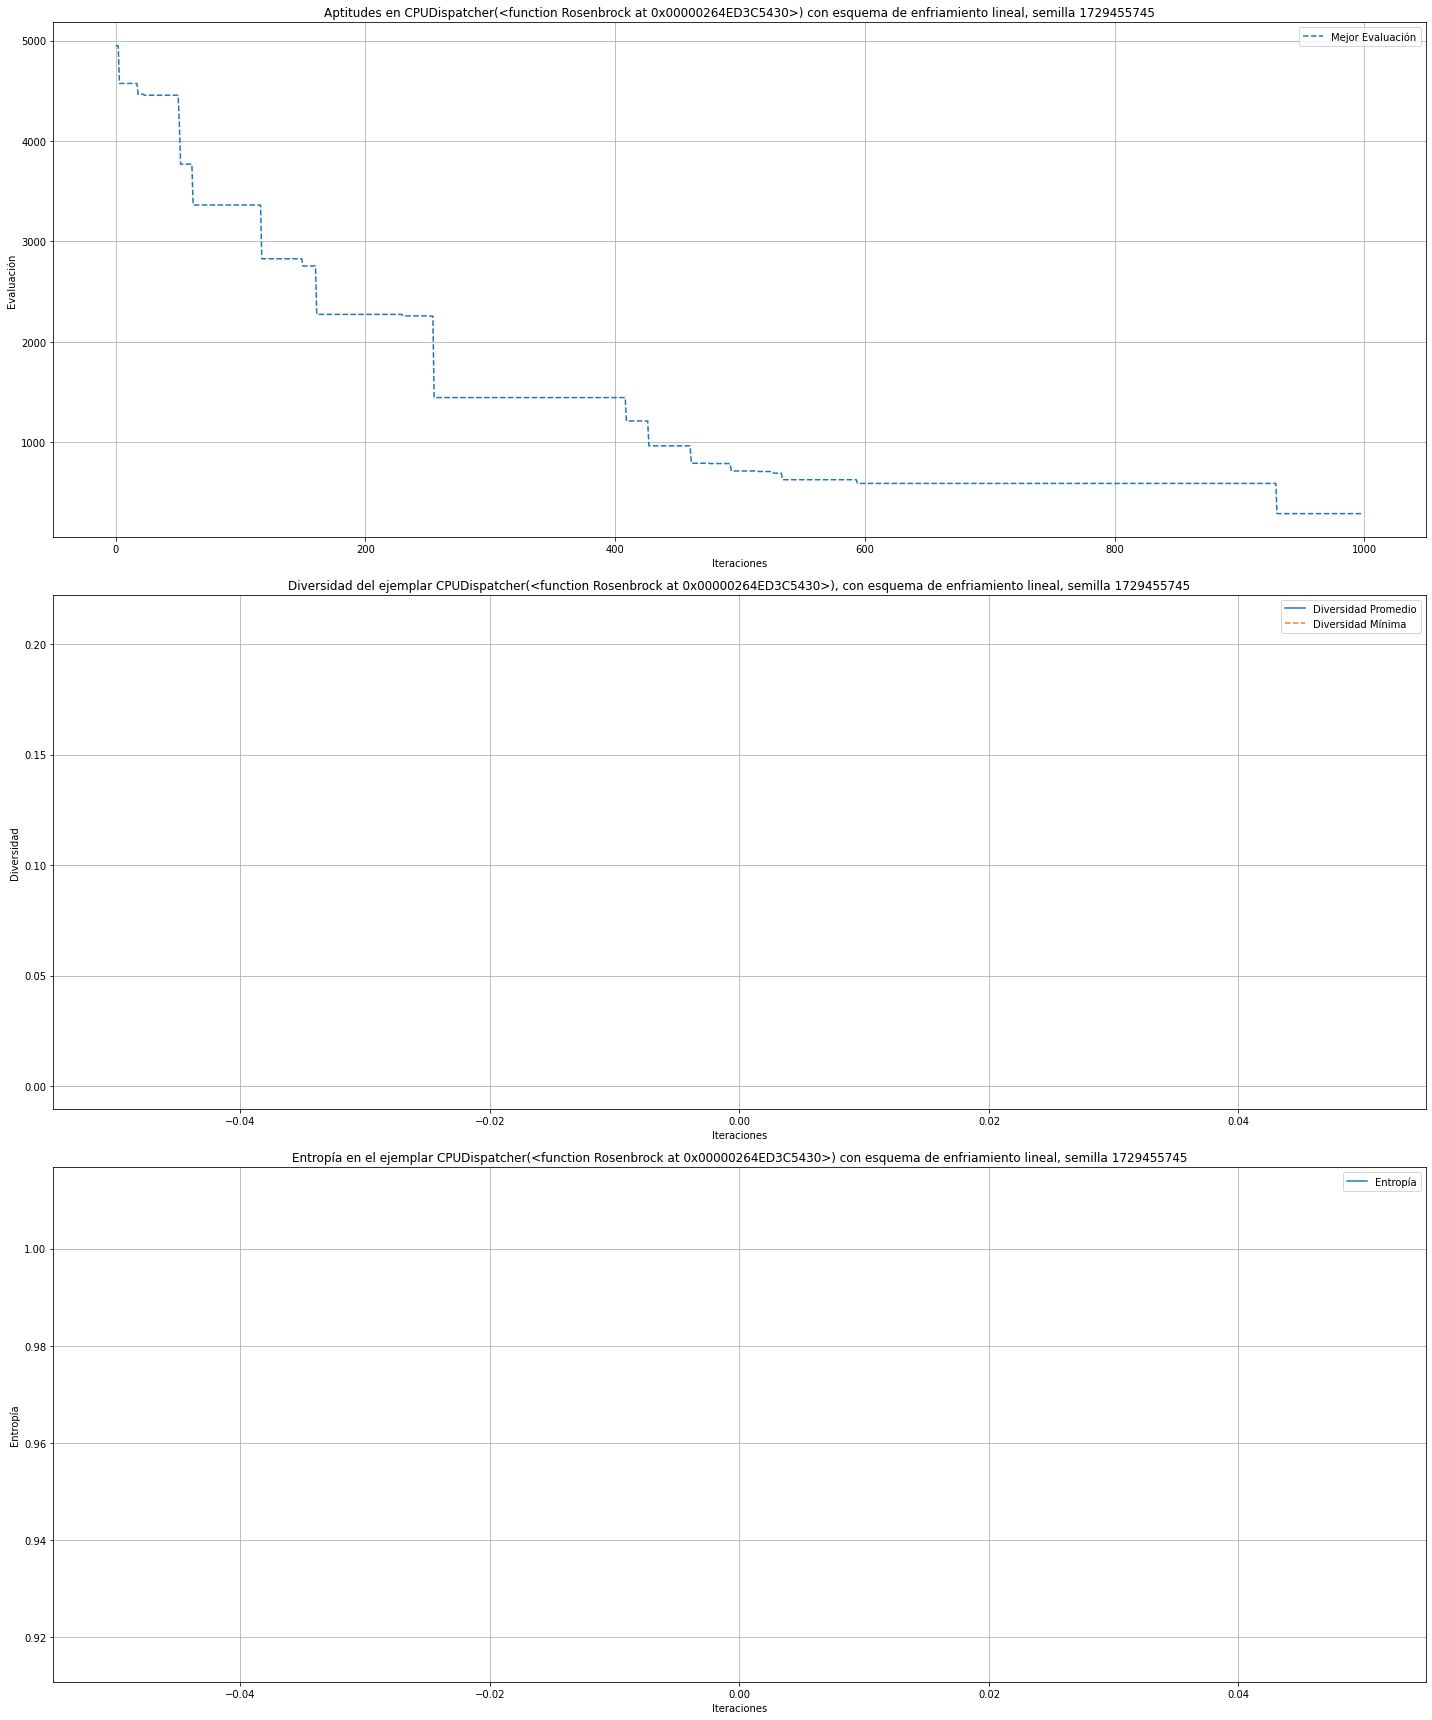

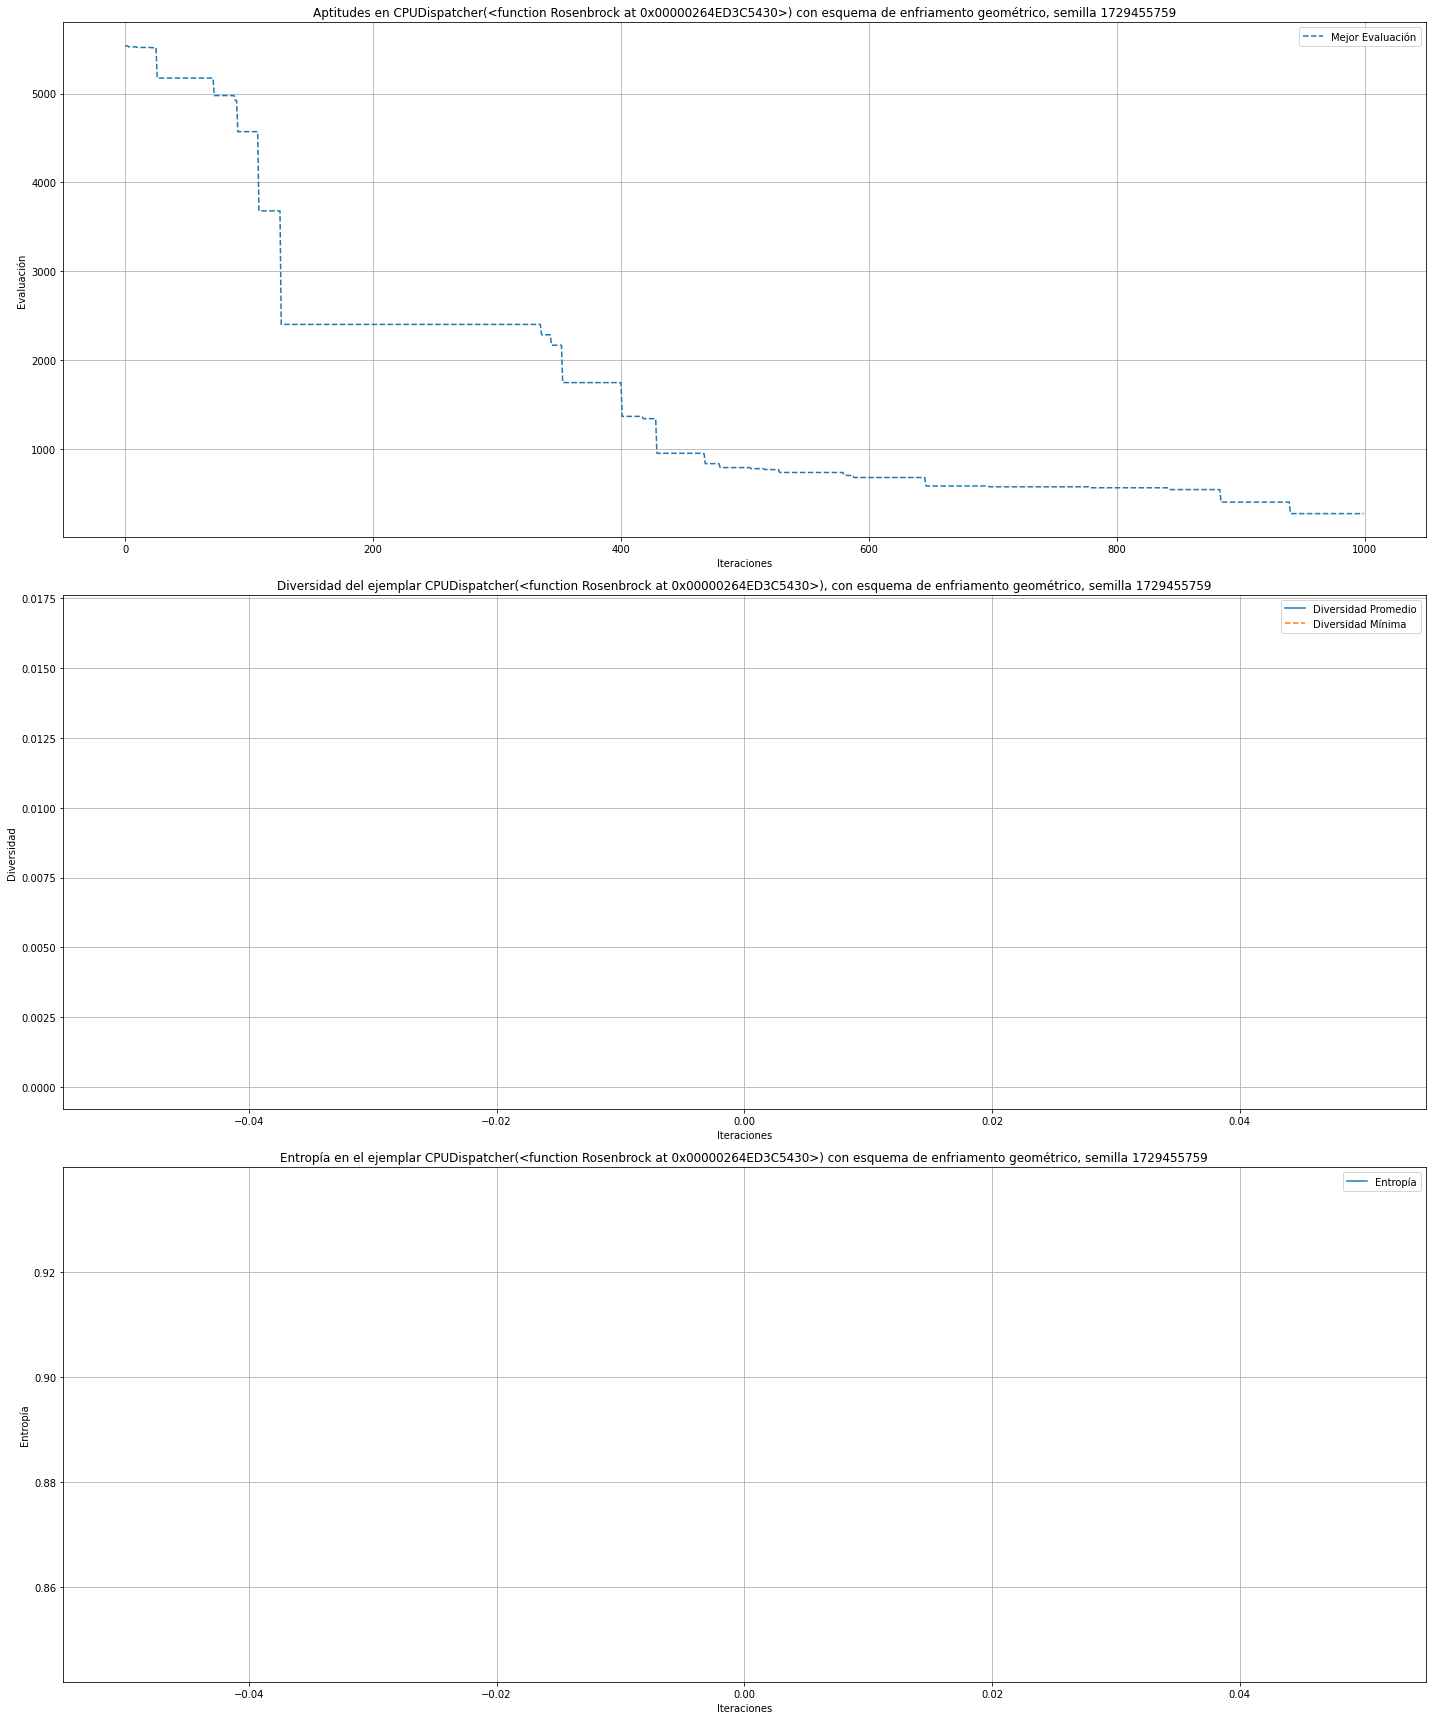

In [172]:
#ejecutar_algoritmo_y_graficar(Rosenbrock, intervaloRosenbrock)